Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer
from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read train data

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/train.csv')
print("Data points count: ", raw_data['id'].count())
raw_data.head()

Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


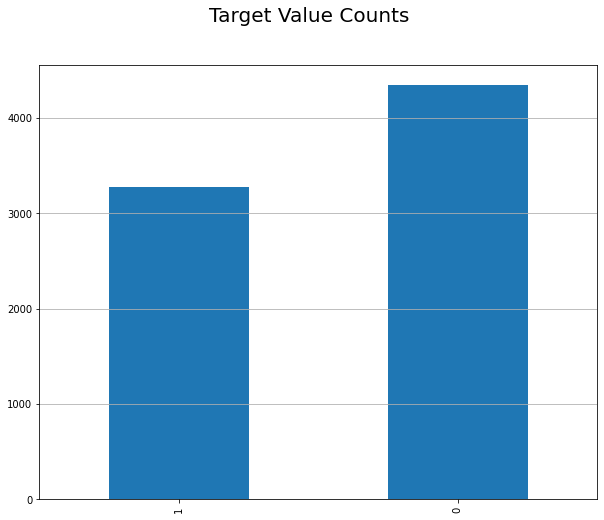

In [4]:
plt.figure(figsize=(10,8))
ax = raw_data['target'].value_counts().sort_values().plot(kind="bar")
ax.grid(axis="y")
plt.suptitle("Target Value Counts", fontsize=20)
plt.show()

## Missing Data

In [5]:
print("Number of missing data for column keyword: ", raw_data['keyword'].isna().sum())
print("Number of missing data for column location: ", raw_data['location'].isna().sum())
print("Number of missing data for column text: ", raw_data['text'].isna().sum())
print("Number of missing data for column target: ", raw_data['target'].isna().sum())

Number of missing data for column keyword:  61
Number of missing data for column location:  2533
Number of missing data for column text:  0
Number of missing data for column target:  0


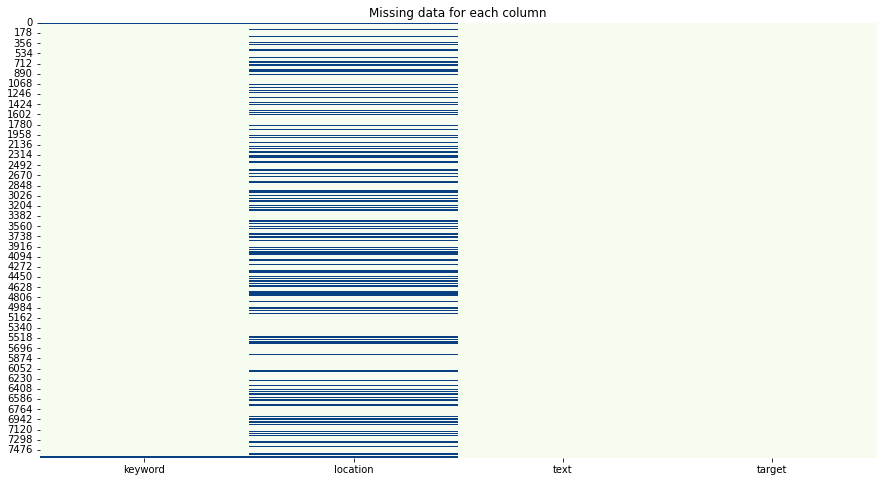

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(raw_data.drop('id', axis=1).isnull(), cbar=False, cmap="GnBu").set_title("Missing data for each column")
plt.show()

## Cleaning Data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


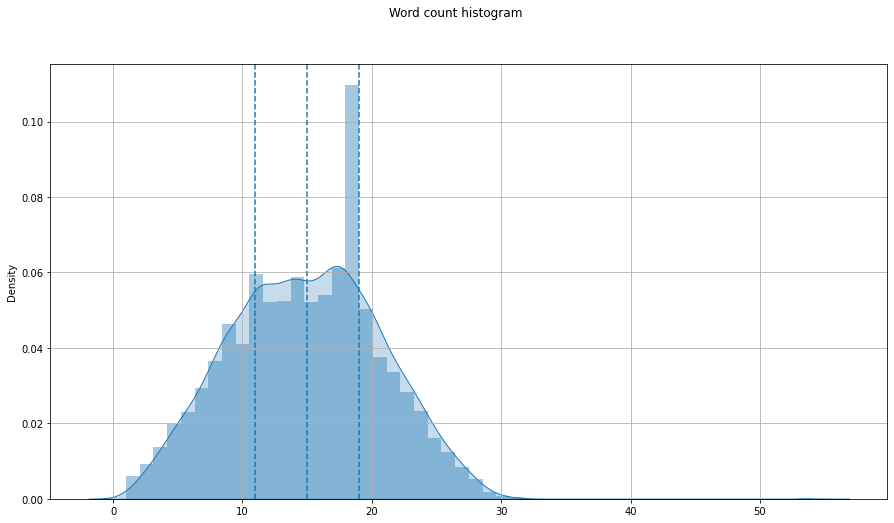

In [7]:
plt.figure(figsize=(15,8))
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(x.split(" ")) )
sns.distplot(raw_data['word_count'].values, hist=True, kde=True, kde_kws={"shade": True})
plt.axvline(raw_data['word_count'].describe()['25%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['50%'], ls="--")
plt.axvline(raw_data['word_count'].describe()['75%'], ls="--")
plt.grid()
plt.suptitle("Word count histogram")
plt.show()
raw_data = raw_data[raw_data['word_count']>2]
raw_data = raw_data.reset_index()

In [8]:
print("25th percentile: ", raw_data['word_count'].describe()['25%'])
print("mean: ", raw_data['word_count'].describe()['50%'])
print("75th percentile: ", raw_data['word_count'].describe()['75%'])

25th percentile:  11.0
mean:  15.0
75th percentile:  19.0


In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from nltk.corpus import stopwords

In [11]:
nltk.download('stop_words')

[nltk_data] Error loading stop_words: Package 'stop_words' not found
[nltk_data]     in index


False

In [16]:
top_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
def clean_text(each_text):
    each_text_no_url = re.sub(r"http\S+", "", each_text)
    text_no_num = re.sub(r'\d+', '', each_text_no_url)
    word_tokens = word_tokenize(text_no_num)
    clean_text = []
    from nltk.corpus import stopwords
    stoplist = set(stopwords.words("english"))
    for word in word_tokens:
        clean_text.append("".join([e for e in word if e.isalnum()]))
    text_with_no_stop_word = [w.lower() for w in clean_text if not w in stoplist]  
    stemmed_text = [stemmer.stem(w) for w in text_with_no_stop_word]
    return " ".join(" ".join(stemmed_text).split())
raw_data['clean_text'] = raw_data['text'].apply(lambda x: clean_text(x))
raw_data['keyword'] = raw_data['keyword'].fillna("none")
raw_data['clean_keyword'] = raw_data['keyword'].apply(lambda x: clean_text(x))

In [17]:
raw_data['keyword_text'] = raw_data['clean_keyword']+" "+ raw_data["clean_text"]

## Prepare train and test data

In [18]:
feature = 'keyword_text'
label = "target"
X_train, X_test,y_train, y_test = model_selection.train_test_split(raw_data[feature],
                                                                   raw_data[label],
                                                                   test_size=0.3,
                                                                   random_state=0, 
                                                                   shuffle=True)

# Gradient Boosting Classifier

In [19]:
X_train_GBC = X_train.values.reshape(-1)
x_test_GBC = X_test.values.reshape(-1)

In [20]:
vectorizer = CountVectorizer()
X_train_GBC = vectorizer.fit_transform(X_train_GBC)
x_test_GBC = vectorizer.transform(x_test_GBC)

In [21]:
model = ensemble.GradientBoostingClassifier(learning_rate=0.1,                                            
                                            n_estimators=2000,
                                            max_depth=9,
                                            min_samples_split=6,
                                            min_samples_leaf=2,
                                            max_features=8,
                                            subsample=0.9)
model.fit(X_train_GBC, y_train)

GradientBoostingClassifier(max_depth=9, max_features=8, min_samples_leaf=2,
                           min_samples_split=6, n_estimators=2000,
                           subsample=0.9)

In [22]:
predicted_prob = model.predict_proba(x_test_GBC)[:,1]
predicted = model.predict(x_test_GBC)
accuracy = metrics.accuracy_score(predicted, y_test)
print("Test accuracy: ", accuracy)
print(metrics.classification_report(y_test, predicted, target_names=["0", "1"]))
print("Test F-scoare: ", metrics.f1_score(y_test, predicted))

Test accuracy:  0.7973568281938326
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1309
           1       0.81      0.69      0.74       961

    accuracy                           0.80      2270
   macro avg       0.80      0.78      0.79      2270
weighted avg       0.80      0.80      0.79      2270

Test F-scoare:  0.7412823397075365


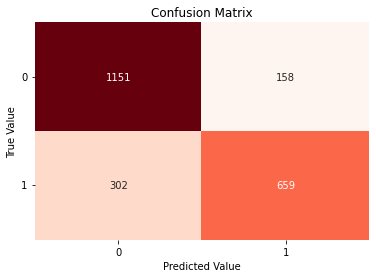

In [23]:
conf_matrix = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()

# LSTM

In [24]:
path_to_glove_file = '/content/drive/MyDrive/glove.6B.300d.txt' 
embedding_dim = 300
learning_rate = 1e-3
batch_size = 1024
epochs = 20
sequence_len = 100

In [25]:
y_train_LSTM = y_train.values.reshape(-1,1)
y_test_LSTM = y_test.values.reshape(-1,1)
print("Training Y shape:", y_train_LSTM.shape)
print("Testing Y shape:", y_test_LSTM.shape)

Training Y shape: (5294, 1)
Testing Y shape: (2270, 1)


In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocabulary Size: ", vocab_size)


Vocabulary Size:  11148


In [27]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=sequence_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=sequence_len)
print("Training X shape: ", X_train.shape)
print("Testing X shape: ", X_test.shape)

Training X shape:  (5294, 100)
Testing X shape:  (2270, 100)


In [28]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [29]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=sequence_len,
                                            trainable=False)

In [30]:
sequence_input = Input(shape=(sequence_len, ), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          3344400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           192128    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [31]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs, 
                    validation_data=(X_test, y_test))


Epoch 1/20
6/6 [==============================] - 67s 9s/step - loss: 0.6628 - accuracy: 0.5865 - val_loss: 0.5642 - val_accuracy: 0.7304
Epoch 2/20
6/6 [==============================] - 52s 8s/step - loss: 0.5534 - accuracy: 0.7459 - val_loss: 0.5152 - val_accuracy: 0.7608
Epoch 3/20
6/6 [==============================] - 52s 8s/step - loss: 0.4975 - accuracy: 0.7733 - val_loss: 0.5032 - val_accuracy: 0.7586
Epoch 4/20
6/6 [==============================] - 53s 9s/step - loss: 0.4711 - accuracy: 0.7873 - val_loss: 0.5166 - val_accuracy: 0.7678
Epoch 5/20
6/6 [==============================] - 51s 8s/step - loss: 0.4525 - accuracy: 0.7956 - val_loss: 0.4896 - val_accuracy: 0.7727
Epoch 6/20
6/6 [==============================] - 52s 9s/step - loss: 0.4220 - accuracy: 0.8128 - val_loss: 0.4769 - val_accuracy: 0.7877
Epoch 7/20
6/6 [==============================] - 51s 8s/step - loss: 0.4016 - accuracy: 0.8241 - val_loss: 0.5025 - val_accuracy: 0.7855
Epoch 8/20
6/6 [==================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


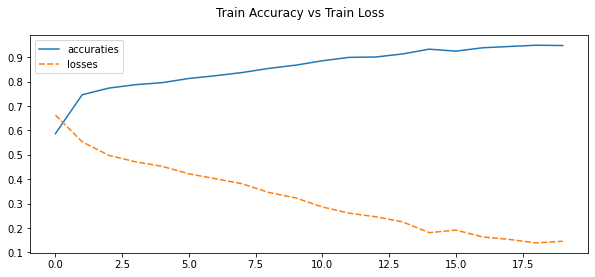

In [39]:
history_dict = history.history
print(history_dict.keys())
accuraties = history_dict['accuracy']
losses = history_dict['loss']
accuraties_losses = list(zip(accuraties,losses))
accuraties_losses_df = pd.DataFrame(accuraties_losses, columns={"accuraties", "losses"})
plt.figure(figsize=(10,4))
plt.suptitle("Train Accuracy vs Train Loss")
sns.lineplot(data=accuraties_losses_df)
plt.show()

In [40]:
predicted = model.predict(X_test, verbose=1, batch_size=10000)
y_predicted = [1 if each > 0.5 else 0 for each in predicted]
score, test_accuracy = model.evaluate(X_test, y_test, batch_size=10000)
print("Test Accuracy: ", test_accuracy)
print(metrics.classification_report(list(y_test), y_predicted))

1/1 [==============================] - 4s 4s/step - loss: 0.7326 - accuracy: 0.7846
Test Accuracy:  0.7845814824104309
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1309
           1       0.80      0.65      0.72       961

    accuracy                           0.78      2270
   macro avg       0.79      0.77      0.77      2270
weighted avg       0.79      0.78      0.78      2270



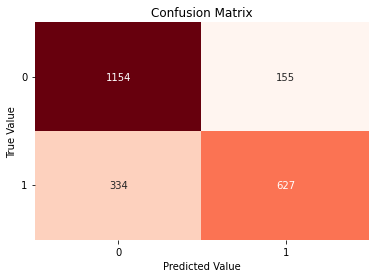

In [41]:
conf_matrix = metrics.confusion_matrix(y_test, y_predicted)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, cbar=False, cmap='Reds', annot=True, fmt='d')
ax.set(xlabel="Predicted Value", ylabel="True Value", title="Confusion Matrix")
ax.set_yticklabels(labels=['0', '1'], rotation=0)
plt.show()